## Dev Notebook

Define and train a neural network in TensorFlow. This model evaluates spamminess by message, i.e. each message is considered independent of all others.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import hashlib
import unicodedata
import re
import string
import itertools

from tensorflow import set_random_seed

# Set random seeds for reproducible results
np.random.seed(42)
set_random_seed(42)

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, LSTM, Input, Bidirectional, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Rough proportion of data in training set
train_split = 0.7
# Max character length of a message, hardcoded in OSRS as 80 chars
max_chars = 80
# Max character length of a username, hardcoded as 12 chars
max_user_chars = 12
# How many messages to look back when calculating metrics
lookback = 10
# Threshold above which a message is classed as spam
spam_thresh = 0.50

dev_split = 0.05

# Get rid of pandas warning
pd.options.mode.chained_assignment = None

tf.__version__

'1.13.0-rc2'

In [3]:
def fbeta_score(beta=1):
    def fbeta(y_true, y_pred):
        y_pred = K.clip(y_pred, 0, 1)

        y_pred_bin = K.round(y_pred)

        tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
        fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
        fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

        precision = tp / (tp + fp)
        recall = tp / (tp + fn)

        beta_squared = beta ** 2
        return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())
    return fbeta

In [4]:
def levenshteinDistance(s1, s2):
    # Checks if s2 is NaN. This isn't perfect but it works. Only s2 can ever be NaN, not s1
    if s2 != s2:
        return 80
    
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

## Load and pre-process data

In [39]:
# Load the dataset

df = pd.read_csv("datasetnew.csv", index_col=0)

In [40]:
# Clean message function. This just replaces unicode characters with ascii equivalents and encodes as ascii

def clean_message(msg):
    return unicodedata.normalize('NFKD', msg).encode('ascii','ignore')

# Clean all messages and de-duplicate

df['cleanmsg'] = df['message'].apply(lambda x: clean_message(x))

# Drop messages that were sent on login, since they have inaccurate data
df = df[~(df['time'] == df['logintime'])].reset_index(drop=True)

# Calculate time since login and time since last message, filling NaN values with time since login

df['time_since_login'] = df['time'] - df['logintime']
df['time_since_last'] = df.groupby(['user', 'logintime'])['time_since_login'].diff()
df['time_since_last'].fillna(df['time_since_login'], inplace=True)

# Calculate rolling mean and std dev, filling NaN stddev values with 2 ** 32 - 1

df['mean'] = df.groupby(['user', 'logintime'])['time_since_last'].apply(
    lambda x: x.rolling(lookback, min_periods=1).mean())
df['std'] = df.groupby(['user', 'logintime'])['time_since_last'].apply(
    lambda x: x.rolling(lookback, min_periods=1).std())
df['std'].fillna(0, inplace=True)

# Calculate Levenshtein distance between pairs of messages

df['lastcleanmsg'] = df.groupby(['user', 'logintime'])['cleanmsg'].shift(1)
df['lv_dist'] = df.apply(lambda x: levenshteinDistance(x['cleanmsg'], x['lastcleanmsg']), axis=1)

# Count message occurrence by user/session grouping
df['msgcount'] = df.groupby(['user', 'logintime']).cumcount()

# Length of the message
df['len'] = df['cleanmsg'].str.len()

# Split the dataset using MD5 hash to make splitting deterministic and repeatable after adding new data
# The split proportion won't be exactly as specified, but it'll be good enough

split_val = (2 ** 32 - 1) * train_split
dev_split_val = (2 ** 32 - 1) * dev_split
df['msgmd5'] = [int(hashlib.md5((row[1]['message'] + str(row[1]['time'])).encode("utf-8")).hexdigest()[0:8], 16) 
                 for row in df.iterrows()]

traindf = df[df['msgmd5'] < split_val]
testdf = df[df['msgmd5'] >= split_val]
df.drop(columns=['msgmd5'], inplace=True)
traindf.drop(columns=['msgmd5'], inplace=True)
testdf.drop(columns=['msgmd5'], inplace=True)

print("Proportion of data in train set: {}".format(len(traindf) / (len(traindf) + len(testdf))))
print("Proportion of data in test set: {}".format(len(testdf) / (len(traindf) + len(testdf))))

Proportion of data in train set: 0.6952511103518961
Proportion of data in test set: 0.30474888964810387


In [46]:
# Create features
# Features we create are as follows:
# The message itself, as an ASCII-encoded 80-length vector
# The sender name, as an ASCII-encoded 12-length vector
# The time since the last message the user has sent
# The average time between messages, averaged over the last 10 messages the user has sent
# The std dev of the time between messages, over the last 10 messages per user. Set to 2 ** 32 - 1 if it is their 1st msg
# Levenshtein distance between this message and the last. Set to 80 (max possible) if it is the person's first message.
# Total messages sent by the person
# Length of the message
# The output, as a manually-labelled binary category indicating spam or no spam

# Create messages feature

encoded_msgs = [list(msg) for msg in np.array(df['cleanmsg'])]
msg_seqs = pad_sequences(encoded_msgs, maxlen=max_chars)
msg_seqs = msg_seqs.reshape((len(msg_seqs), max_chars, 1))

X_train_msg = msg_seqs[traindf.index]
X_test_msg = msg_seqs[testdf.index]

# Create username feature

encoded_users = [list(clean_message(user)) for user in np.array(df['user'])]
user_seqs = pad_sequences(encoded_users, maxlen=max_user_chars)
user_seqs = user_seqs.reshape((len(user_seqs), max_user_chars, 1))

X_train_user = user_seqs[traindf.index]
X_test_user = user_seqs[testdf.index]

# Create additional features

X_train_misc = traindf[['mean', 'std', 'lv_dist', 'time_since_last', 'msgcount', 'len']].values
X_test_misc = testdf[['mean', 'std', 'lv_dist', 'time_since_last', 'msgcount', 'len']].values

# Create output vectors

Y_train = np.array(traindf['spam'])
Y_test = np.array(testdf['spam'])

print("Train set entries: {} non-spam, {} spam".format(len(Y_train) - sum(Y_train), sum(Y_train)))
print("Test set entries: {} non-spam, {} spam".format(len(Y_test) - sum(Y_test), sum(Y_test)))

Train set entries: 3061 non-spam, 1009 spam
Test set entries: 1315 non-spam, 469 spam


## Set up and train model

In [47]:
# Define Keras model constructor

'''def create_model(l1=32, l2=8, d1=64, dense_activation='relu'):
    msg_input = Input(shape=(max_chars, 1))
    user_input = Input(shape=(max_user_chars, 1))
    misc_input = Input(shape=(4,))
    X_msg = Bidirectional(LSTM(l1))(msg_input)
    X_user = LSTM(l2)(user_input)
    X = Concatenate()([X_msg, X_user, misc_input])
    X = Dense(d1, activation=dense_activation)(X)
    output = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=[msg_input, user_input, misc_input], outputs=output)
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(name='precision'), Recall(name='recall'), fbeta_score()]
    )
    return model'''
def create_model(l1=16, l2=8, d1=32, dense_activation='relu'):
    msg_input = Input(shape=(max_chars, 1))
    misc_input = Input(shape=(X_test_misc.shape[1],))
    X_msg = Bidirectional(LSTM(l1))(msg_input)
    X = Concatenate()([X_msg, misc_input])
    X = Dense(d1, activation=dense_activation)(X)
    output = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=[msg_input, misc_input], outputs=output)
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', Precision(name='precision'), Recall(name='recall'), fbeta_score()]
    )
    return model

In [ ]:
# Train the model, checking performance on validation set. 

K.clear_session()

model = create_model()
print(model.summary())
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='min')

history = model.fit(
    [X_train_msg, X_train_misc], 
    Y_train, 
    epochs=100,
    validation_data=([X_test_msg, X_test_misc], Y_test), 
    batch_size=64, 
    verbose=2,
    callbacks=[reduce_lr_loss]
)

K.set_learning_phase(0)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 1)        0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 32)           2304        input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           bidirectional[0][0]              
                                                                 input_2[0][0]                    
__________

## Evaluate Model

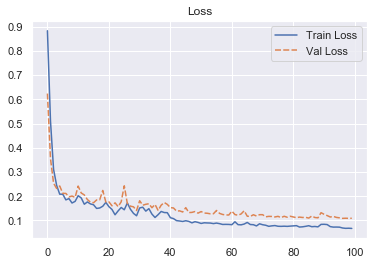

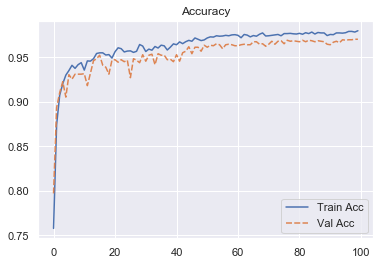

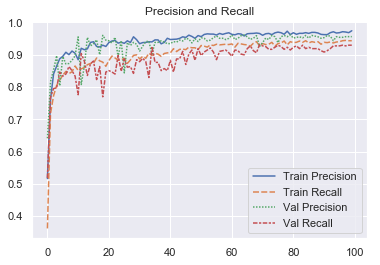

In [37]:
sns.lineplot(
    data=pd.DataFrame({'Train Loss': history.history['loss'], 'Val Loss': history.history['val_loss']})
).set_title('Loss')
plt.show()

sns.lineplot(
    data=pd.DataFrame({'Train Acc': history.history['acc'], 'Val Acc': history.history['val_acc']})
).set_title('Accuracy')
plt.show()

sns.lineplot(
    data=pd.DataFrame({
        'Train Precision': history.history['precision'], 
        'Train Recall': history.history['recall'],
        'Val Precision': history.history['val_precision'], 
        'Val Recall': history.history['val_recall'],
    })
).set_title('Precision and Recall')
plt.show()

In [24]:
# Make predictions on entire dataset and re-split into test and train sets

allpreds = model.predict(seqs)

df['pred'] = allpreds
df['predclass'] = allpreds > spam_thresh
testdf = df.iloc[testdf.index]
traindf = df.iloc[traindf.index]

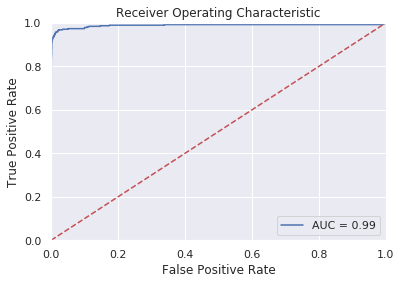

In [25]:
fpr, tpr, threshold = roc_curve(Y_test, testdf['pred'])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Text(0.5,1,'Test set confusion matrix')

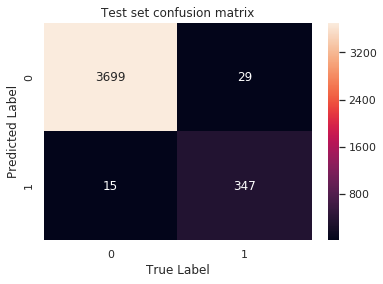

In [26]:
# Confusion Matrices

conf = confusion_matrix(testdf['predclass'], testdf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='d')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Test set confusion matrix")

conf = confusion_matrix(traindf['predclass'], traindf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='g')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Train set confusion matrix")

In [28]:
# Show misclassified test and train samples

display(testdf[testdf['spam'] != testdf['predclass']])
display(traindf[traindf['spam'] != traindf['predclass']])

,user,message,spam,pred,predclass
3,Arbuckleee,"Massive 2.1b giveaway happening right now, sea...",True,0.228947,False
602,RNG 5049,"Naefyo has Reached his time limit, he forfeits...",True,0.081249,False
604,RNG 5049,"Parthanax246 Is too far Away, he forfeits his ...",True,0.360644,False
605,RNG 5049,You only need to trade once! The current queue...,True,0.219726,False
618,RNG 5049,"Time limit reached, declining",True,0.036275,False
857,RNG 5006,"Gentwestbp has Reached his time limit, he forf...",True,0.129442,False
1556,Huntriyl1212,3333333333333,True,0.496055,False
1639,LilCuhCuh,Selling Fda approved lab tested knock off drag...,False,0.977568,True
1979,Swerve,Follow for free shit@@@@@@@@@,False,0.741902,True
2078,Spenny261,~~~~~ F O L L O W F O R D R O P P A R T Y~~~~~,False,0.998939,True


,user,message,spam,pred,predclass
1,Arbuckleee,Hurry up before all of the gold is given away !!!,True,0.471849,False
616,RNG 5049,"Thorleifsen Is too far Away, he forfeits his g...",True,0.030673,False
848,RNG 5006,You only need to trade once! The current queue...,True,0.220741,False
1140,RNG 5006,"Thinkr has Reached his time limit, he forfeits...",True,0.085672,False
1554,dgtergehe,22222222222222,True,0.476531,False
2429,Unexpose,Twitch aegunexposed i do weekly giveaways!,True,0.438099,False
2440,Unexpose,"Ever get bored and have no one to watch, twitc...",True,0.027081,False
2485,Unexpose,Go to twitch and hmu with a follow aegunexposed,True,0.060301,False
4772,RNG223,Gave away bank here yesterday,True,0.001810,False
4842,RNG223,Legit doubling last call!!!,True,0.116261,False


In [29]:
# Test cumulative spamminess of a user

users = {}
spampred = []

for idx, row in testdf.iterrows():
    prior, num = users.get(row['user'], (1 - spam_thresh, 1))
    spampred.append(row['pred'] > 1 - prior)
    users[row['user']] = ((prior * num + row['pred']) / (num + 1), num + 1)
    
testdf['cumulativespam'] = spampred

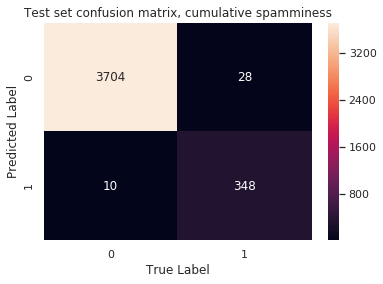

,user,message,spam,pred,predclass,cumulativespam
3,Arbuckleee,"Massive 2.1b giveaway happening right now, sea...",True,0.228947,False,False
602,RNG 5049,"Naefyo has Reached his time limit, he forfeits...",True,0.081249,False,False
605,RNG 5049,You only need to trade once! The current queue...,True,0.219726,False,False
618,RNG 5049,"Time limit reached, declining",True,0.036275,False,False
857,RNG 5006,"Gentwestbp has Reached his time limit, he forf...",True,0.129442,False,False
1556,Huntriyl1212,3333333333333,True,0.496055,False,False
1639,LilCuhCuh,Selling Fda approved lab tested knock off drag...,False,0.977568,True,True
1979,Swerve,Follow for free shit@@@@@@@@@,False,0.741902,True,True
2078,Spenny261,~~~~~ F O L L O W F O R D R O P P A R T Y~~~~~,False,0.998939,True,True
2342,NascentScorp,10m giveaway/dp twitch/primeduels join the !Di...,True,0.004889,False,False


In [30]:
conf = confusion_matrix(testdf['cumulativespam'], testdf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='g')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Test set confusion matrix, cumulative spamminess")
plt.show()

testdf[testdf['spam'] != testdf['cumulativespam']]

In [31]:
# Save as before, only on the training set

users = {}
spampred = []

for idx, row in traindf.iterrows():
    prior, num = users.get(row['user'], (1 - spam_thresh, 1))
    spampred.append(row['pred'] > 1 - prior)
    users[row['user']] = ((prior * num + row['pred']) / (num + 1), num + 1)
    
traindf['cumulativespam'] = spampred

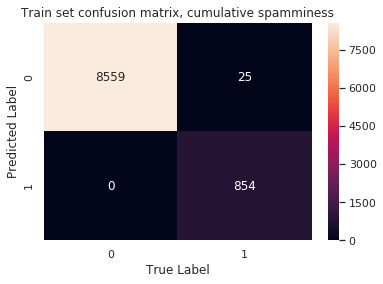

,user,message,spam,pred,predclass,cumulativespam
1,Arbuckleee,Hurry up before all of the gold is given away !!!,True,0.471849,False,False
616,RNG 5049,"Thorleifsen Is too far Away, he forfeits his g...",True,0.030673,False,False
1554,dgtergehe,22222222222222,True,0.476531,False,False
2429,Unexpose,Twitch aegunexposed i do weekly giveaways!,True,0.438099,False,False
2440,Unexpose,"Ever get bored and have no one to watch, twitc...",True,0.027081,False,False
2485,Unexpose,Go to twitch and hmu with a follow aegunexposed,True,0.060301,False,False
4772,RNG223,Gave away bank here yesterday,True,0.001810,False,False
4842,RNG223,Legit doubling last call!!!,True,0.116261,False,False
9424,<img=2>slave2ba,Bypass ge limits at [Ge surplus] cc!,True,0.269464,False,False
10149,Dropslukey12,Drop party all fall in!,True,0.020406,False,False


In [32]:
conf = confusion_matrix(traindf['cumulativespam'], traindf['spam'])
fig = sns.heatmap(conf, annot=True, fmt='g')
fig.set_xlabel("True Label")
fig.set_ylabel("Predicted Label")
fig.set_title("Train set confusion matrix, cumulative spamminess")
plt.show()

traindf[traindf['spam'] != traindf['cumulativespam']]

## Save and export model

In [33]:
# Save the model
model.save("antispam.h5")
model.save_weights('antispam_weights.h5')

In [34]:
# Saves model as .txt files for loading in Java

def save_weights_txt(layer):
    config = layer.get_config()
    allweights = layer.get_weights()
    name = config["name"]
    for i, weights in enumerate(allweights):
            np.savetxt("model_weights/{}_params_{}.txt".format(name, i), weights)

for layer in model.layers:
    config = layer.get_config()
    allweights = layer.get_weights()
    name = config["name"]
    if "bidirectional" in name:
        save_weights_txt(layer.forward_layer)
        save_weights_txt(layer.backward_layer)
    else:
        save_weights_txt(layer)

In [35]:
# Saves model as .npy files for loading in Java

def save_weights_npy(layer):
    config = layer.get_config()
    allweights = layer.get_weights()
    name = config["name"]
    for i, weights in enumerate(allweights):
            np.save("model_weights/{}_params_{}.npy".format(name, i), weights)

for layer in model.layers:
    config = layer.get_config()
    allweights = layer.get_weights()
    name = config["name"]
    if "bidirectional" in name:
        save_weights_npy(layer.forward_layer)
        save_weights_npy(layer.backward_layer)
    else:
        save_weights_npy(layer)